(scale_heights)=
# Scale heights for typical atmospheric soundings

## Plot McClatchey's US Standard Atmospheres

There are five different average profiles for the tropics, subarctic summer, subarctic winter, midlatitude summer, midlatitude winter.  These are called the US Standard Atmospheres.  This notebook shows how to read and plot the soundings, and calculate the pressure and density scale heights.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticks
import numpy as np
import a301_lib
from pathlib import Path
import pandas as pd
import pprint

******************************
context imported. Front of path:
/home/phil/work



In [2]:
soundings_folder= a301_lib.data_share / Path('soundings')
sounding_files = list(soundings_folder.glob("*csv"))

### Reading the soundings files into pandas

There are five soundings.
The soundings have six columns and 33 rows (i.e. 33 height levels).  The variables are
 z, press, temp, rmix, den, o3den -- where rmix is the mixing ratio of water vapor, den is the dry air density and o3den is the ozone density.  The units are 
 m, pa, K, kg/kg, kg/m^3, kg/m^3
 
 I will read the 6 column soundings into a [pandas (panel data) DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html), which is like a matrix except the columns can be accessed by column name in addition to column number.  The main advantage for us is that it's easier to keep track of which variables we're plotting

In [3]:
name_dict=dict()
sound_dict=dict()
for item in sounding_files:
    name_dict[item.stem]=item
pprint.pprint(name_dict)

for item in sounding_files:
    sound_dict[item.stem]=pd.read_csv(item)

{'midsummer': PosixPath('/home/phil/work/data_share/soundings/midsummer.csv'),
 'midwinter': PosixPath('/home/phil/work/data_share/soundings/midwinter.csv'),
 'subsummer': PosixPath('/home/phil/work/data_share/soundings/subsummer.csv'),
 'subwinter': PosixPath('/home/phil/work/data_share/soundings/subwinter.csv'),
 'tropics': PosixPath('/home/phil/work/data_share/soundings/tropics.csv')}


# Use pd.DataFrame.head to see first 5 lines

In [4]:
for key,value in sound_dict.items():
    print(f"sounding: {key}\n{sound_dict[key].head()}")

sounding: subsummer
   Unnamed: 0       z     press   temp     rmix     den         o3den
0           0     0.0  101000.0  287.0  0.00910  1.2200  4.900000e-08
1           1  1000.0   89600.0  282.0  0.00600  1.1100  5.400000e-08
2           2  2000.0   79290.0  276.0  0.00420  0.9971  5.600000e-08
3           3  3000.0   70000.0  271.0  0.00269  0.8985  5.800001e-08
4           4  4000.0   61600.0  266.0  0.00165  0.8077  6.000000e-08
sounding: tropics
   Unnamed: 0       z     press   temp     rmix     den         o3den
0           0     0.0  101300.0  300.0  0.01900  1.1670  5.600000e-08
1           1  1000.0   90400.0  294.0  0.01300  1.0640  5.600000e-08
2           2  2000.0   80500.0  288.0  0.00929  0.9689  5.400000e-08
3           3  3000.0   71500.0  284.0  0.00470  0.8756  5.100000e-08
4           4  4000.0   63300.0  277.0  0.00266  0.7951  4.700000e-08
sounding: midsummer
   Unnamed: 0       z     press   temp     rmix     den         o3den
0           0     0.0  101300.0 

We use these keys to get a dataframe with 6 columns, and 33 levels.  Here's an example for the midsummer sounding

In [5]:
midsummer=sound_dict['midsummer']
print(midsummer.head())
list(midsummer.columns)

   Unnamed: 0       z     press   temp     rmix     den         o3den
0           0     0.0  101300.0  294.0  0.01400  1.1910  6.000000e-08
1           1  1000.0   90200.0  290.0  0.00930  1.0800  6.000000e-08
2           2  2000.0   80200.0  285.0  0.00585  0.9757  6.000000e-08
3           3  3000.0   71000.0  279.0  0.00343  0.8846  6.200001e-08
4           4  4000.0   62800.0  273.0  0.00189  0.7998  6.400000e-08


['Unnamed: 0', 'z', 'press', 'temp', 'rmix', 'den', 'o3den']

### Plot  temp and vapor mixing ratio rmix ($\rho_{H2O}/\rho_{air}$)

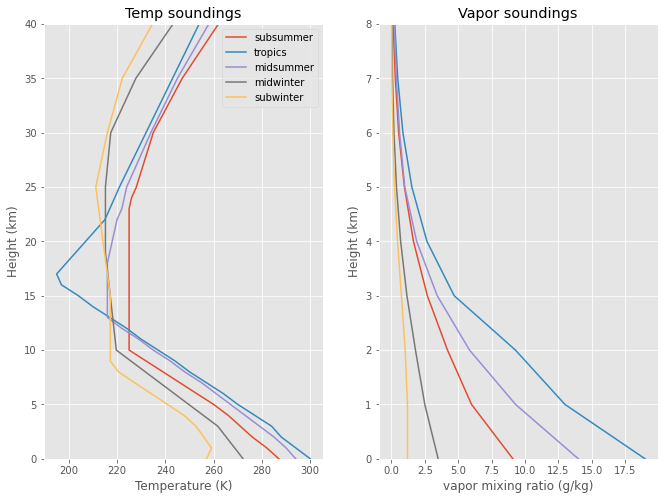

In [6]:
%matplotlib inline
plt.style.use('ggplot')
meters2km=1.e-3
plt.close('all')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,8))
for a_name,df in sound_dict.items():
    ax1.plot(df['temp'],df['z']*meters2km,label=a_name)
    ax1.set(ylim=(0,40),title='Temp soundings',ylabel='Height (km)',
       xlabel='Temperature (K)')

    ax2.plot(df['rmix']*1.e3,df['z']*meters2km,label=a_name)
    ax2.set(ylim=(0,8),title='Vapor soundings',ylabel='Height (km)',
       xlabel='vapor mixing ratio (g/kg)')
ax1.legend();

## Calculating scale heights for temperature and air density

Here is equation 1 of the [hydrostatic balance notes](http://clouds.eos.ubc.ca/~phil/courses/atsc301/hydrostat.html#equation-hydro)

$$\frac{ 1}{\overline{H_p}} =  \overline{ \left ( \frac{1 }{H} \right )} = \frac{\int_{0 }^{z}\!\frac{1}{H} dz^\prime  }{z-0} $$

where

$$H=R_d T/g$$

and here is the Python code to do that integral:

In [7]:
g=9.8  #don't worry about g(z) for this exercise
Rd=287.  #kg/m^3
def calcScaleHeight(T,p,z):
    """
    Calculate the pressure scale height H_p
    
    Parameters
    ----------
    
    T: vector (float)
      temperature (K)
      
    p: vector (float) of len(T)
      pressure (pa)
      
    z: vector (float) of len(T
      height (m)
      
    Returns
    -------
    
    Hbar: vector (float) of len(T)
      pressure scale height (m)
    
    """
    dz=np.diff(z)
    TLayer=(T[1:] + T[0:-1])/2.
    oneOverH=g/(Rd*TLayer)
    Zthick=z[-1] - z[0]
    oneOverHbar=np.sum(oneOverH*dz)/Zthick
    Hbar = 1/oneOverHbar
    return Hbar

Similarly, equation (5) of the [hydrostatic balance notes](http://clouds.eos.ubc.ca/~phil/courses/atsc301/hydrostat.html#equation-hydro)
is:

$$\frac{d\rho }{\rho} = - \left ( \frac{1 }{H} + 
                   \frac{1 }{T} \frac{dT }{dz} \right ) dz \equiv - \frac{dz }{H_\rho} $$
                   
Which leads to 

$$\frac{ 1}{\overline{H_\rho}}  = \frac{\int_{0 }^{z}\!\left [ \frac{1}{H} + \frac{1 }{T} \frac{dT }{dz} \right ] dz^\prime  }{z-0} $$

and the following python function:

In [8]:
def calcDensHeight(T,p,z):
    """
    Calculate the density scale height H_rho
    
    Parameters
    ----------
    
    T: vector (float)
      temperature (K)
      
    p: vector (float) of len(T)
      pressure (pa)
      
    z: vector (float) of len(T
      height (m)
      
    Returns
    -------
    
    Hbar: vector (float) of len(T)
      density scale height (m)
    """
    dz=np.diff(z)
    TLayer=(T[1:] + T[0:-1])/2.
    dTdz=np.diff(T)/np.diff(z)
    oneOverH=g/(Rd*TLayer) + (1/TLayer*dTdz)
    Zthick=z[-1] - z[0]
    oneOverHbar=np.sum(oneOverH*dz)/Zthick
    Hbar = 1/oneOverHbar
    return Hbar

### How do $\overline{H_p}$ and $\overline{H_\rho}$ compare for the tropical sounding?

In [9]:
sounding='tropics'
#
# grab the dataframe and get the sounding columns
#
df=sound_dict[sounding]
z=df['z'].values
Temp=df['temp'].values
press=df['press'].values

In [10]:
#
# limit calculation to bottom 10 km
#
hit=z<10000.
zL,pressL,TempL=(z[hit],press[hit],Temp[hit])
rhoL=pressL/(Rd*TempL)
Hbar= calcScaleHeight(TempL,pressL,zL)
Hrho= calcDensHeight(TempL,pressL,zL)
print("pressure scale height for the {} sounding is {:5.2f} km".format(sounding,Hbar*1.e-3))
print("density scale height for the {} is {:5.2f} km".format(sounding,Hrho*1.e-3))

pressure scale height for the tropics sounding is  7.96 km
density scale height for the tropics is  9.74 km


### How well do these average values represent the pressure and density profiles?

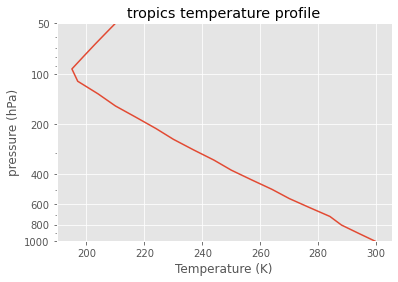

In [11]:
theFig,theAx=plt.subplots(1,1)
theAx.semilogy(Temp,press/100.)
#
# need to flip the y axis since pressure decreases with height
#
theAx.invert_yaxis()
tickvals=[1000,800, 600, 400, 200, 100, 50,1]
theAx.set_yticks(tickvals)
majorFormatter = ticks.FormatStrFormatter('%d')
theAx.yaxis.set_major_formatter(majorFormatter)
theAx.set_yticklabels(tickvals)
theAx.set_ylim([1000.,50.])
theAx.set_title('{} temperature profile'.format(sounding))
theAx.set_xlabel('Temperature (K)')
theAx.set_ylabel('pressure (hPa)');

Now check the hydrostatic approximation by plotting the pressure column against

$$p(z) = p_0 \exp \left (-z/\overline{H_p} \right )$$

vs. the actual sounding p(T):

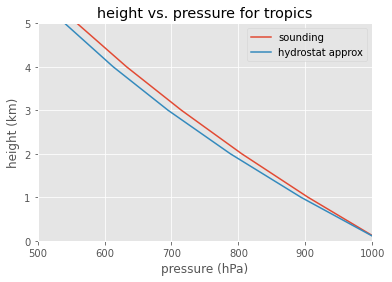

In [12]:
fig,theAx=plt.subplots(1,1)
hydroPress=pressL[0]*np.exp(-zL/Hbar)
theAx.plot(pressL/100.,zL/1000.,label='sounding')
theAx.plot(hydroPress/100.,zL/1000.,label='hydrostat approx')
theAx.set_title('height vs. pressure for tropics')
theAx.set_xlabel('pressure (hPa)')
theAx.set_ylabel('height (km)')
theAx.set_xlim([500,1000])
theAx.set_ylim([0,5])
tickVals=[500, 600, 700, 800, 900, 1000]
theAx.set_xticks(tickVals)
theAx.set_xticklabels(tickVals)
theAx.legend(loc='best');

Again plot the hydrostatic approximation

$$\rho(z) = \rho_0 \exp \left (-z/\overline{H_\rho} \right )$$

vs. the actual sounding $\rho(z)$:

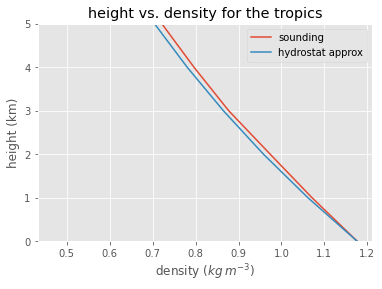

In [13]:
fig,theAx=plt.subplots(1,1)
hydroDens=rhoL[0]*np.exp(-zL/Hrho)
theAx.plot(rhoL,zL/1000.,label='sounding')
theAx.plot(hydroDens,zL/1000.,label='hydrostat approx')
theAx.set_title('height vs. density for the tropics')
theAx.set_xlabel('density ($kg\,m^{-3}$)')
theAx.set_ylabel('height (km)')
theAx.set_ylim([0,5])
theAx.legend(loc='best');

<a name="oct7assign"></a>

### Assignment4 -- (preview)

Add cells to this notebook to:

1\.  Print out the density and pressure scale heights for each of the five soundings

2\.  Define a function that takes a sounding dataframe and returns the "total precipitable water", which is defined as:

$$W = \int_0^{z_{top}} \rho_v dz $$

Do a change of units to convert $kg\,m^{-2}$ to $cm\,m^{-2}$ using the density of liquid water (1000 $kg\,m^{-3}$) -- that is, turn the kg of water in the 1 square meter column into cubic meters and turn that into $cm/m^{-2}$

3\.  Use your function to print out W for all five soundings